# RGCN

Predict forest harvest volumes (posek_iglavcev, posek_listavcev) for Sestoj (forest stands) using a heterogeneous relational graph neural network (RGCN) built from a SQLite forest database.

### Install

In [ ]:
pip install numpy pandas torch torch-geometric scikit-learn sentence-transformers

### Import

In [ ]:
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam 
from torch_geometric.data import HeteroData
from torch_geometric.nn import HeteroConv, RGCNConv, LayerNorm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sentence_transformers import SentenceTransformer 
import warnings 
warnings.filterwarnings("ignore") 

⚠️ Important: Before running the code also run ../../datasets/razdeli.sql and save the database 

### Setup

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
EMBEDDING_MODEL_NAME = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2" 
HIDDEN_DIM = 128 # 256 cuda crash OOM
LR = 0.001 
EPOCHS = 2500 
DROPOUT = 0.2 
TARGETS = ["posek_iglavcev", "posek_listavcev"] 

### Graph data preparation

We need to clean the data as some of the values are not there NaN.  
For better result we also embedd data into vector for better representation.  
Also we need to change string keys used in database ti 

In [ ]:
""" Clean text and make it lowercase """
def normalize_text(x): 
    if pd.isna(x): 
        return "" 
    return str(x).lower().strip() 

""" Use Sentence Transformer to embed text into dense numeric vectors dimensions of 384"""
def embed_text(model, series): 
    return model.encode(series.fillna("").astype(str).map(normalize_text).tolist(), show_progress_bar=False) 

""" Standarize the data """
def standardize(df, cols): 
    scaler = StandardScaler()
    df[cols] = scaler.fit_transform(df[cols]) 
    return df 

""" Convers string foreign / primary key into numerical as required by pyg """
def build_id_map(df: pd.DataFrame, pk: str): 
    return {str(v): i for i, v in enumerate(df[pk].astype(str).values)} 

""" Match foreign keys with destination node id """
def build_edge_index(src_df, dst_map, src_pk, fk_col, src_map): 
    src, dst = [], [] 
    for _, r in src_df.iterrows(): 
        fk = str(r[fk_col]) 
        if fk in dst_map: 
            src.append(src_map[str(r[src_pk])]) 
            dst.append(dst_map[fk]) 
    return torch.tensor([src, dst], dtype=torch.long) 

""" Helper function to return metrics  """
def calculate_metrics(y_true, y_pred): 
    y_true, y_pred = y_true.cpu().numpy(), y_pred.cpu().numpy() 
    return { 
        "r2": r2_score(y_true, y_pred), 
        "mae": mean_absolute_error(y_true, y_pred), 
        "rmse": np.sqrt(mean_squared_error(y_true, y_pred)) 
    } 

### Build a graph

load_and_build_graph: 

In [ ]:
def load_and_build_graph(db_path): 
    conn = sqlite3.connect(db_path) 
    tables = {t: pd.read_sql(f"SELECT * FROM {t}", conn) for t in ["Enota", "Obmocje", "Revir", "Krajevna_Enota", "Relief", "Tarife", "Odsek", "Sestoj", "Sestava_Gozda"]} 
    conn.close() 
    model = SentenceTransformer(EMBEDDING_MODEL_NAME) 
    data = HeteroData() 
    data["Enota"].x = torch.tensor(embed_text(model, tables["Enota"]["gge_naziv"])) 
    data["Obmocje"].x = torch.tensor(embed_text(model, tables["Obmocje"]["ggo_naziv"])) 
    data["Revir"].x = torch.tensor(embed_text(model, tables["Revir"]["revir_naziv"])) 
    data["Krajevna_Enota"].x = torch.tensor(embed_text(model, tables["Krajevna_Enota"]["ke_naziv"])) 
    data["Odsek"].x = torch.tensor(standardize(tables["Odsek"], ["povrsina", "gojitveni_razred_ggo", "gojitveni_razred_gge", "kategorija_gozd", "ohranjenost_gozda", "polozaj_pokrajine", "pozar_ogrozenost", "intenzivnost_gospodarjenja", "rastiscni_tip", "rastiscni_koeficient", "vezani_ogljik", "letni_ponor_ogljika"]).iloc[:, 5:].values, dtype=torch.float) 
    data["Relief"].x = torch.tensor(standardize(tables["Relief"], ["relief", "lega", "nagib", "s_nadmorska_visina", "z_nadmorska_visina", "kamnina", "delez_kamnitosti", "delez_skalovitosti", "odprtost", "odprt_gurs"]).iloc[:, 1:].values, dtype=torch.float) 
    data["Tarife"].x = torch.tensor(standardize(tables["Tarife"], tables["Tarife"].columns[1:].tolist()).iloc[:, 1:].values, dtype=torch.float) 
    data["Sestava_Gozda"].x = torch.tensor(standardize(tables["Sestava_Gozda"], tables["Sestava_Gozda"].columns[1:].tolist()).iloc[:, 1:].values, dtype=torch.float) 
    sestoj_feats = ["povrsina", "razvojna_faza", "gojitvena_smer", "zasnova", "sklep", "negovanost", "pomladek_ha", "pomladek_zasnova", "zaloga_iglavcev", "zaloga_listavcev", "zaloga_skupno"] 
    data["Sestoj"].x = torch.tensor(standardize(tables["Sestoj"], sestoj_feats).iloc[:, 3:14].values, dtype=torch.float) 
    data["Sestoj"].y = torch.tensor(tables["Sestoj"][TARGETS].values, dtype=torch.float) 
    ids = { 
        "Enota": build_id_map(tables["Enota"], "gge"), 
        "Obmocje": build_id_map(tables["Obmocje"], "ggo"), 
        "Revir": build_id_map(tables["Revir"], "revir"), 
        "Krajevna_Enota": build_id_map(tables["Krajevna_Enota"], "ke"), 
        "Odsek": build_id_map(tables["Odsek"], "odsek"), 
        "Sestoj": build_id_map(tables["Sestoj"], "sestoj"), 
        "Relief": build_id_map(tables["Relief"], "odsek"), 
        "Tarife": build_id_map(tables["Tarife"], "odsek"), 
        "Sestava_Gozda": build_id_map(tables["Sestava_Gozda"], "sestoj"), 
    } 
    data["Odsek", "in", "Obmocje"].edge_index = build_edge_index(tables["Odsek"], ids["Obmocje"], "odsek", "ggo", ids["Odsek"]) 
    data["Odsek", "in", "Enota"].edge_index = build_edge_index(tables["Odsek"], ids["Enota"], "odsek", "gge", ids["Odsek"]) 
    data["Odsek", "in", "Krajevna_Enota"].edge_index = build_edge_index(tables["Odsek"], ids["Krajevna_Enota"], "odsek", "ke", ids["Odsek"]) 
    data["Odsek", "in", "Revir"].edge_index = build_edge_index(tables["Odsek"], ids["Revir"], "odsek", "revir", ids["Odsek"]) 
    data["Sestoj", "part_of", "Odsek"].edge_index = build_edge_index(tables["Sestoj"], ids["Odsek"], "sestoj", "odsek", ids["Sestoj"]) 
    data["Relief", "describes", "Odsek"].edge_index = build_edge_index(tables["Relief"], ids["Odsek"], "odsek", "odsek", ids["Relief"]) 
    data["Tarife", "applies_to", "Odsek"].edge_index = build_edge_index(tables["Tarife"], ids["Odsek"], "odsek", "odsek", ids["Tarife"]) 
    data["Sestava_Gozda", "describes", "Sestoj"].edge_index = build_edge_index(tables["Sestava_Gozda"], ids["Sestoj"], "sestoj", "sestoj", ids["Sestava_Gozda"]) 
    num_nodes = data["Sestoj"].num_nodes 
    indices = torch.randperm(num_nodes) 
    train_size = int(0.8 * num_nodes) 
    val_size = int(0.1 * num_nodes) 
    data["Sestoj"].train_mask = torch.zeros(num_nodes, dtype=torch.bool) 
    data["Sestoj"].val_mask = torch.zeros(num_nodes, dtype=torch.bool) 
    data["Sestoj"].test_mask = torch.zeros(num_nodes, dtype=torch.bool) 
    data["Sestoj"].train_mask[indices[:train_size]] = True 
    data["Sestoj"].val_mask[indices[train_size:train_size+val_size]] = True 
    data["Sestoj"].test_mask[indices[train_size+val_size:]] = True 
    return data 

### Model inicialization

In [ ]:
class RGCN(torch.nn.Module):
    def __init__(self, metadata, in_dims, hidden_channels, out_channels):
        super().__init__()
        
        self.proj = nn.ModuleDict({
            node_type: nn.Linear(in_dim, hidden_channels)
            for node_type, in_dim in in_dims.items()
        })
        
        self.convs = nn.ModuleList()
        self.norms = nn.ModuleList()
        
        num_layers = 2
        num_relations = len(metadata[1]) 
        
        for _ in range(num_layers):
            conv_dict = {}
            for i, edge_type in enumerate(metadata[1]):
                conv_dict[edge_type] = RGCNConv(
                    (hidden_channels, hidden_channels), 
                    hidden_channels, 
                    num_relations=num_relations
                )
            
            self.convs.append(HeteroConv(conv_dict, aggr='mean'))
            norm_dict = nn.ModuleDict({
                node_type: LayerNorm(hidden_channels, mode="node")
                for node_type in metadata[0]
            })
            self.norms.append(norm_dict)

        self.lin = nn.Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        x_dict = {
            node_type: F.relu(self.proj[node_type](x))
            for node_type, x in x_dict.items()
        }

        edge_type_dict = {}
        for i, edge_type in enumerate(edge_index_dict.keys()):
            edge_type_dict[edge_type] = torch.full(
                (edge_index_dict[edge_type].size(1),), i, 
                dtype=torch.long, device=next(iter(x_dict.values())).device
            )

        for conv, norm_dict in zip(self.convs, self.norms):
            new_x_dict = conv(x_dict, edge_index_dict, edge_type_dict)
            
            for node_type, x in new_x_dict.items():
                x = norm_dict[node_type](x)
                x = F.relu(x)
                x = F.dropout(x, p=0.2, training=self.training)
                x_dict[node_type] = x

        return self.lin(x_dict["Sestoj"])


### Training a model

In [ ]:
def train_model(data): 
    data = data.to(DEVICE) 
    in_dims = { 
        node_type: data[node_type].x.shape[1] 
        for node_type in data.node_types
    } 
    model = RGCN(data.metadata(), in_dims, HIDDEN_DIM, 2).to(DEVICE) 
    optimizer = Adam(model.parameters(), lr=LR) 
    criterion = nn.MSELoss() 
    #criterion = nn.L1Loss()
    best_val_loss = float('inf') 
    for epoch in range(1, EPOCHS + 1): 
        model.train() 
        optimizer.zero_grad() 
        out = model(data.x_dict, data.edge_index_dict) 
        loss = criterion(out[data["Sestoj"].train_mask], data["Sestoj"].y[data["Sestoj"].train_mask]) 
        loss.backward() 
        optimizer.step() 
        model.eval() 
        with torch.no_grad(): 
            val_out = model(data.x_dict, data.edge_index_dict) 
            val_loss = criterion(val_out[data["Sestoj"].val_mask], data["Sestoj"].y[data["Sestoj"].val_mask]) 
            if epoch % 100 == 0: 
                metrics = calculate_metrics(data["Sestoj"].y[data["Sestoj"].val_mask], val_out[data["Sestoj"].val_mask]) 
                print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, R2: {metrics["r2"]:.4f}') 
                if val_loss < best_val_loss: 
                    best_val_loss = val_loss 
                    torch.save(model.state_dict(), 'best_forest_rgcn.pt')
    return model 

### Testing a model

In [ ]:
def test_model(model, data): 
    model.load_state_dict(torch.load('best_forest_rgcn.pt')) 
    model.eval() 
    with torch.no_grad(): 
        out = model(data.x_dict, data.edge_index_dict) 
        out = torch.clamp(out, min=0.0)
        y_true = data["Sestoj"].y[data["Sestoj"].test_mask]
        y_pred = out[data["Sestoj"].test_mask]

        metrics = calculate_metrics(y_true, y_pred) 

        print("\n--- Predictions vs Actual Values ---")
        #for i in range(y_true.size(0)):
        #    print(f"Actual: {y_true[i].cpu().numpy()}, Predicted: {y_pred[i].cpu().numpy()}")

        print("\n--- Final Test Metrics ---") 
        print(f"R2: {metrics['r2']:.4f}") 
        print(f"MAE: {metrics['mae']:.4f}") 
        print(f"MSE: {metrics['rmse']**2:.4f}") 
        print(f"RMSE: {metrics['rmse']:.4f}") 

### Running a model 

In [ ]:
if __name__ == "__main__": 
    db_path = "../../datasets/forest_db.sqlite" 
    print("Building Graph...") 
    forest_graph = load_and_build_graph(db_path)
    print("Starting Training...") 
    trained_model = train_model(forest_graph) 
    test_model(trained_model, forest_graph)

### Vizualization

Vizualization of our results 

##### Comparison of model MAE using different aggregation methods

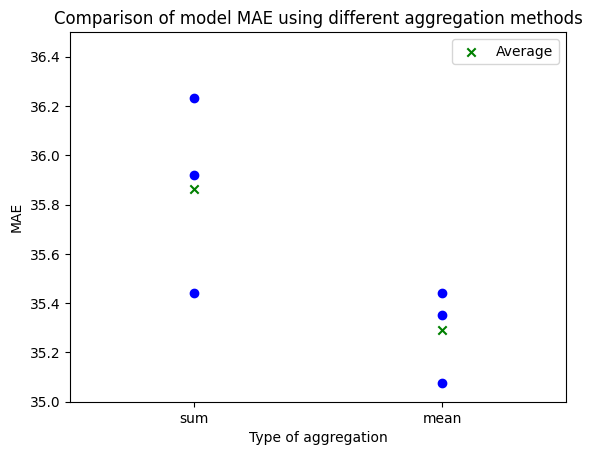

In [12]:
left_values = [35.4409, 36.2337, 35.9196]     
right_values = [35.0761, 35.3504, 35.4430]    

plt.scatter([1]*len(left_values), left_values, color="blue")
plt.scatter([2]*len(right_values), right_values, color="blue")

plt.scatter([1,2], [sum(left_values) / len(left_values), sum(right_values) / len(right_values)], color="green", marker="x", label="Average")

plt.title("Comparison of model MAE using different aggregation methods")
plt.ylabel("MAE")
plt.xlabel("Type of aggregation")
plt.xticks([1, 2], ["sum", "mean"])
plt.legend()

plt.xlim(0.5, 2.5)
plt.ylim(35, 36.5)
plt.show()
